## Задание 1. Time series, LSTM

In [40]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler

In [41]:
sell_prices_df = pd.read_csv('sell_prices.csv')
calendar_df = pd.read_csv('calendar.csv')
sales_train_validation_df = pd.read_csv('sales_train_validation.csv')

In [42]:
date_index = calendar_df['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [43]:
sales_train_validation_df['item_store_id'] = sales_train_validation_df.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
DF_Sales = sales_train_validation_df.loc[:,'d_1':'d_1913'].T
DF_Sales.columns = sales_train_validation_df['item_store_id'].values

DF_Sales = pd.DataFrame(DF_Sales).set_index([dates_list])
DF_Sales.index = pd.to_datetime(DF_Sales.index)
DF_Sales.head()

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,...,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0


<Axes: >

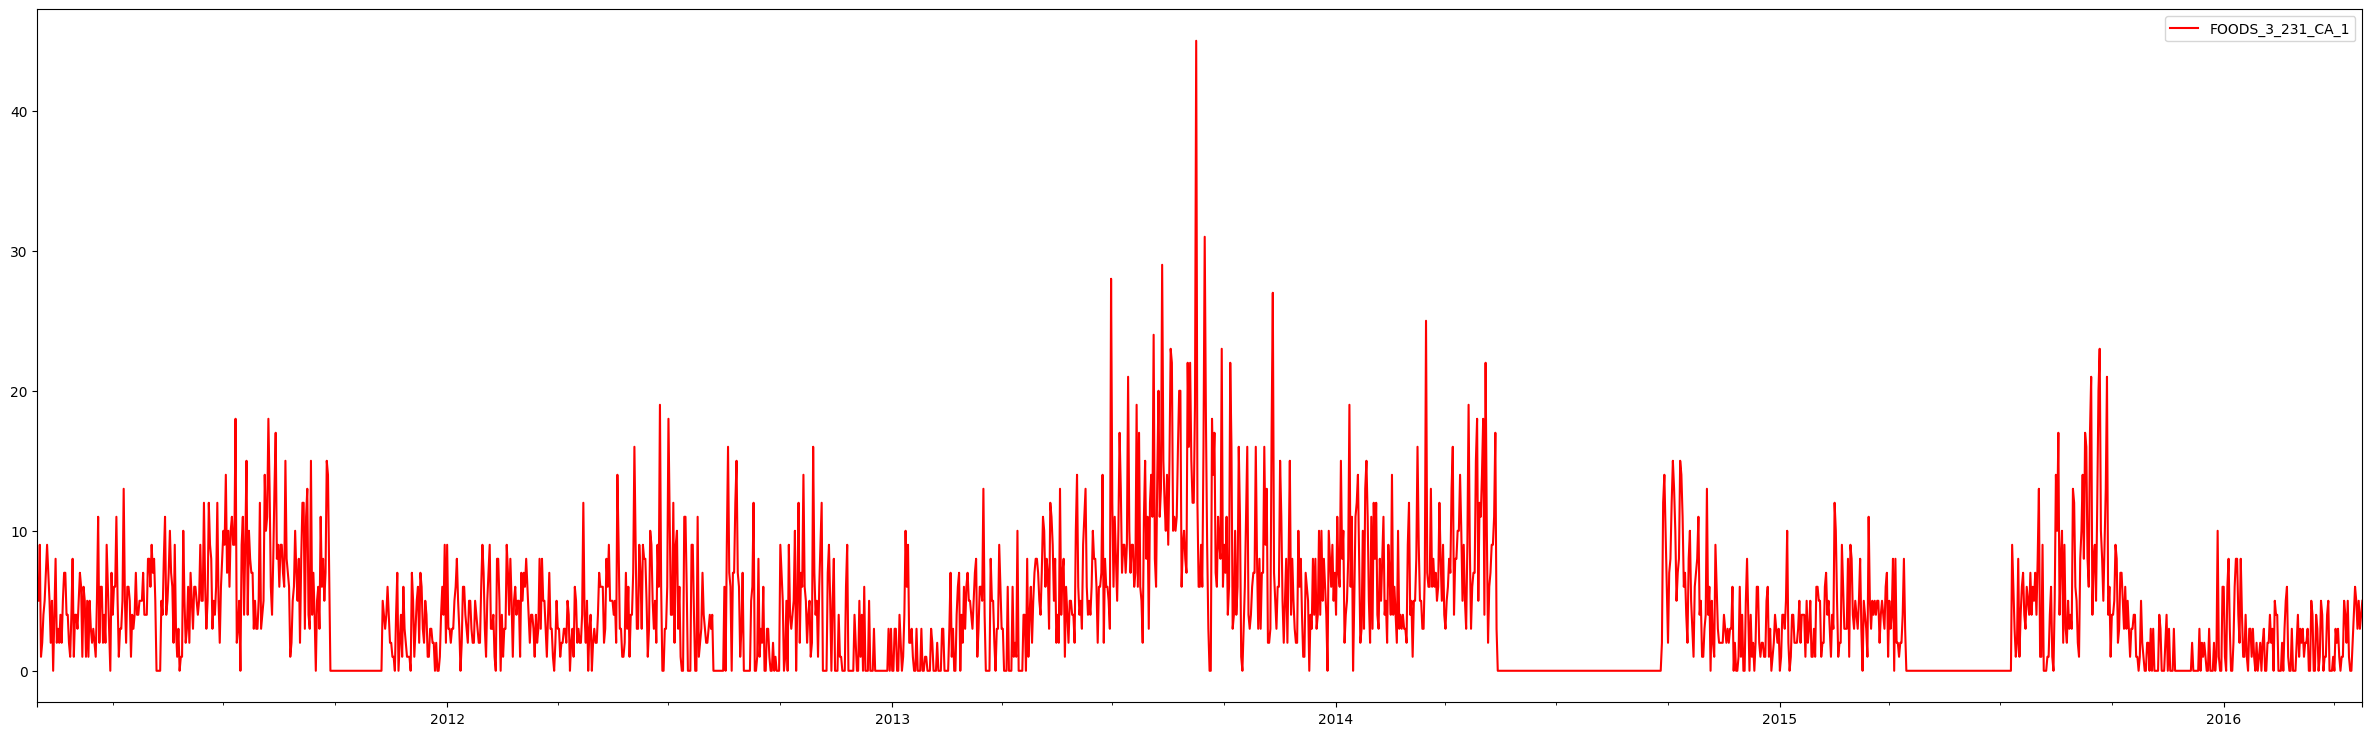

In [44]:
index = 2455
y = pd.DataFrame(DF_Sales.iloc[:,index]).set_index([dates_list])
y.index = pd.to_datetime(y.index)
y.plot(figsize=(30, 9),color='red')

In [45]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        x.append(data[i:(i+seq_length)])
        y.append(data[i+seq_length])

    return np.array(x),np.array(y)

In [46]:
data = np.array(y)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(data.reshape(-1, 1))

In [47]:
seq_length = 31
x, y = sliding_windows(train_data_normalized, seq_length)

In [48]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

data_x = torch.Tensor(np.array(x))
data_y = torch.Tensor(np.array(y))

train_x = torch.Tensor(np.array(x[0:train_size]))
train_y = torch.Tensor(np.array(y[0:train_size]))

test_x = torch.Tensor(np.array(x[train_size:len(x)]))
test_y = torch.Tensor(np.array(y[train_size:len(y)]))

In [49]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)
        
        c_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)
        
        _, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
       
        return out

In [50]:
num_epochs = 100
learning_rate = 1e-3
input_size = 1
hidden_size = 64
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)


for epoch in range(num_epochs): 
    lstm.train()
    outputs = lstm(train_x)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y)
    loss.backward()
    optimizer.step()
       
    lstm.eval()
    valid = lstm(test_x)
    vall_loss = criterion(valid, test_y)
    
    if epoch % 25 == 0:
        print(f"Epoch: {epoch}, loss: {loss} valid loss:  {vall_loss}")
print(f"Epoch: {epoch}, loss: {loss} valid loss:  {vall_loss}")

Epoch: 0, loss: 0.7718942761421204 valid loss:  0.8937945365905762
Epoch: 25, loss: 0.10435996949672699 valid loss:  0.056345172226428986
Epoch: 50, loss: 0.037732239812612534 valid loss:  0.02031763084232807
Epoch: 75, loss: 0.03344310075044632 valid loss:  0.021611643955111504
Epoch: 99, loss: 0.032480403780937195 valid loss:  0.02193734236061573


Text(0.5, 0, 'Date')

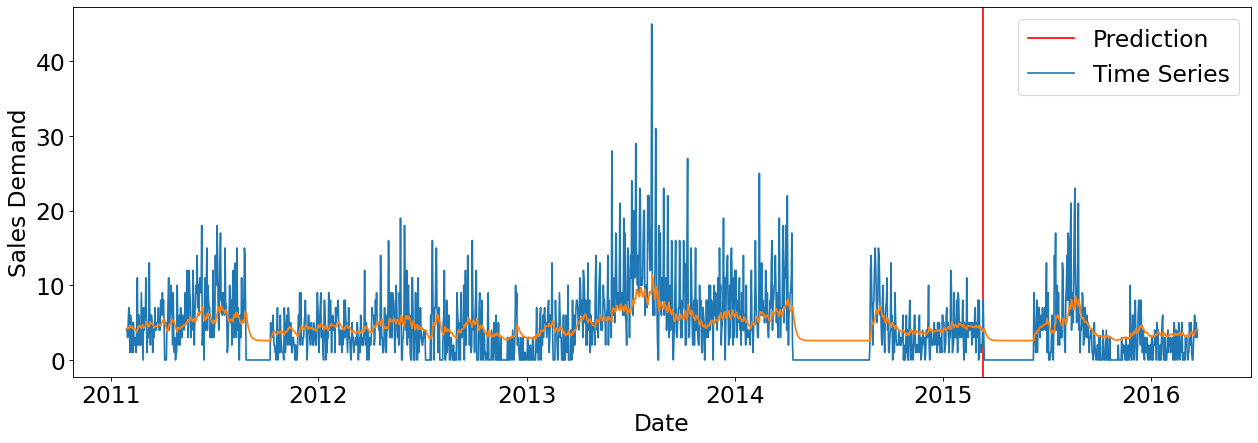

In [51]:
#целиком
lstm.eval()
train_predict = lstm(data_x)
data_predict = train_predict.data.numpy()
data_y_plot = data_y.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
data_y_plot = scaler.inverse_transform(data_y_plot)

df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-32]])
df_labels = pd.DataFrame(data_y_plot)
df_labels = df_labels.set_index([dates_list[:-32]])

plt.figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot(df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)

Text(0.5, 0, 'Date')

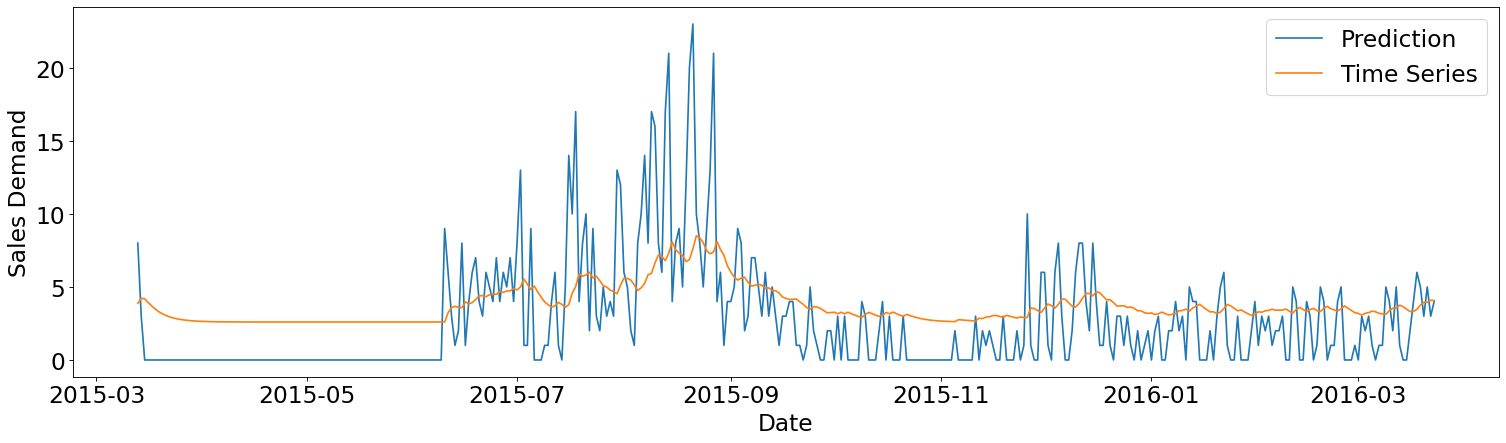

In [52]:
#только тест
plt.figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-test_x.size()[0]:][0])
plt.plot(df_predict.iloc[-test_x.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)

In [53]:
#RMSE
np.sqrt(((data_y_plot[-test_x.size()[0]:] - data_predict[-test_x.size()[0]:] ) ** 2).mean())

np.float32(3.3325336)

## Задание 2. Классификация текста, BERT

In [54]:
import re
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

from transformers import AdamW
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split

/home/bob1ch/Рабочий стол/DScourse_attestations/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [55]:
device = torch.device('cuda')
print(device)

cuda


In [56]:
data = pd.read_csv('IMDB Movie Reviews.csv')

In [57]:
X, y = data['text'].values, data['sentiment'].apply(lambda x: 0 if x == 'neg' else 1).values

<Axes: >

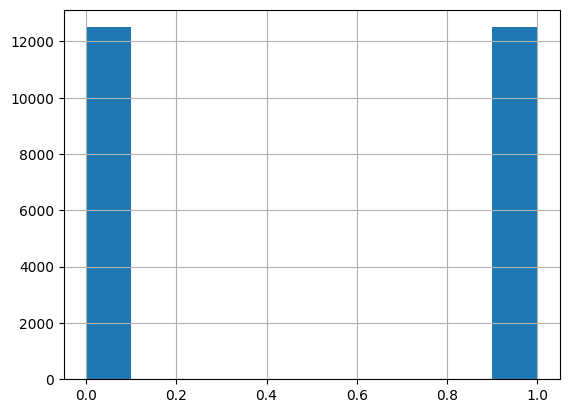

In [58]:
data['sentiment'].apply(lambda x: 0 if x == 'neg' else 1).hist()
#классы выглядят сбалансированными

In [59]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """

    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    text = re.sub(r'<br /><br />', ' ', text)

    return text

In [60]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [61]:
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [62]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [63]:
encoded_reviews = [tokenizer.encode(sent, add_special_tokens=True, truncation=True) for sent in X]
#суть такова, что sent не помещались в токенизатор, и поэтому пришлось добавить truncation=True, и в связи с этим max_len является максимально возможным, а именно 512
#без truncation max_len выдавало порядка 3000

max_len = max([len(sent) for sent in encoded_reviews])
print('Max length: ', max_len)

Max length:  512


In [64]:
MAX_LEN = 512

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  My daughter liked it but I was aghast, that a character in this movie smokes. As if it isn't awful enough to see "product placement" actors like Bruce Willis who smoke in their movies - at least children movies should be more considerate! I wonder: was that intentional? Did big tobacco "sponsor" the film? What does it take to ban smoking from films? At least films intended for children and adolescents. My daughter liked it but I was aghast, that a character in this movie smokes. As if it isn't awful enough to see "product placement" actors like Bruce Willis who smoke in their movies - at least children movies should be more considerate! I wonder: was that intentional? Did big tobacco "sponsor" the film? What does it take to ban smoking from films? At least films intended for children and adolescents.
Token IDs:  [np.int64(101), np.int64(2026), np.int64(2684), np.int64(4669), np.int64(2009), np.int64(2021), np.int64(1045), np.int64(2001), np.int64(12943), np.int64(14949), np.

/home/bob1ch/Рабочий стол/DScourse_attestations/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2888: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [65]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [66]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 31 μs, sys: 1 μs, total: 32 μs
Wall time: 35.8 μs


In [67]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [68]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [69]:
device = torch.device("cuda")
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.658635   |     -      |     -     |   25.52  
   1    |   40    |   0.537145   |     -      |     -     |   25.04  
   1    |   60    |   0.326864   |     -      |     -     |   24.23  
   1    |   80    |   0.290180   |     -      |     -     |   25.33  
   1    |   100   |   0.325994   |     -      |     -     |   25.91  
   1    |   120   |   0.354571   |     -      |     -     |   24.40  
   1    |   140   |   0.256978   |     -      |     -     |   25.70  
   1    |   160   |   0.290080   |     -      |     -     |   25.20  
   1    |   180   |   0.287389   |     -      |     -     |   25.33  
   1    |   200   |   0.270171   |     -      |     -     |   24.09  
   1    |   220   |   0.283325   |     -      |     -     |   24.13  
   1    |   240   |   0.220688   |     -      |     -     |   24.61  


In [70]:
from sklearn.metrics import accuracy_score, roc_curve, auc
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs
    
def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [71]:
import matplotlib.pyplot as plt

AUC: 0.9850
Accuracy: 93.89%


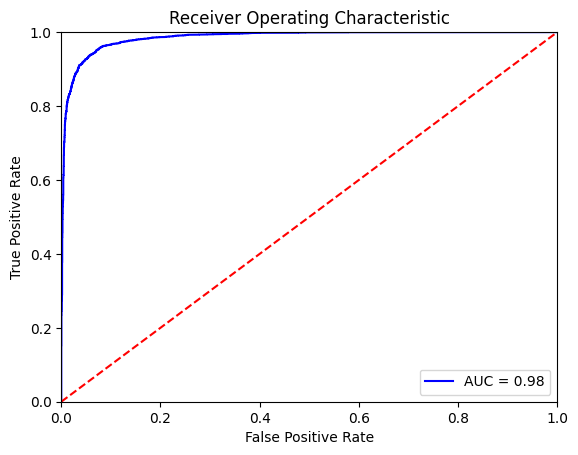

In [72]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

#### Metrics

In [98]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [102]:
y_pred = np.argmax(probs, axis=-1)
y_true = val_labels.detach().numpy()
print(f"""accuracy: {(y_true == y_pred).mean()}
precision: {precision_score(y_true, y_pred)}
recall: {recall_score(y_true, y_pred)}
f1_score: {f1_score(y_true, y_pred)}""")
#так как классы у нас сбалансированны, то могли бы использовать только accuracy
#Так как полнота и точность близки к единице, то и f1-score тоже близок к единице(0,939), что в свою очердь является очень хорошим результатом

accuracy: 0.9389333333333333
precision: 0.9381770145310436
recall: 0.9406622516556291
f1_score: 0.9394179894179894


## Задание 3

In [80]:
import cv2
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import transforms 

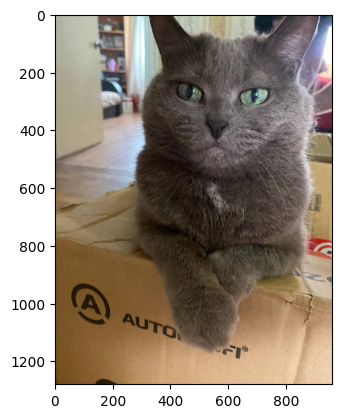

In [81]:
#моя кошка муся
img_plot = cv2.cvtColor(cv2.imread('муся.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img_plot)

In [82]:
def get_torch_tensor(img):
    img = cv2.imread(img)
    convert_tensor = torchvision.transforms.ToTensor()
    img=convert_tensor(img)
    img=torch.tensor(img)
    return img.unsqueeze_(0)

In [83]:
detection_model = torchvision.models.detection.retinanet_resnet50_fpn_v2(weights='COCO_V1')
detection_model.eval()

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [84]:
pred = detection_model(get_torch_tensor('муся.jpg'))[0]

/tmp/ipykernel_2064/3795300989.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img=torch.tensor(img)


In [85]:
pred

{'boxes': tensor([[ 273.1496,    0.0000,  915.5323, 1175.2407],
         [ 281.2827,    0.0000,  909.2189, 1162.9977],
         [ 281.2827,    0.0000,  909.2189, 1162.9977],
         [ 118.4352,  103.2103,  943.8903, 1240.2250],
         [ 281.2827,    0.0000,  909.2189, 1162.9977],
         [ 281.2827,    0.0000,  909.2189, 1162.9977],
         [ 281.2827,    0.0000,  909.2189, 1162.9977],
         [ 281.2827,    0.0000,  909.2189, 1162.9977],
         [   9.1489,  812.8594,  908.4966, 1202.1313],
         [ 281.2827,    0.0000,  909.2189, 1162.9977],
         [ 203.8371,   75.9535,  235.7813,  118.2721],
         [ 262.7705,   21.3760,  916.5371, 1188.6991],
         [  33.4789,  834.2679,  881.9632, 1254.2379],
         [ 259.2635,   25.3486,  901.0303, 1189.4614],
         [  11.4277,  722.6847,  956.3671, 1242.6404],
         [ 862.5422,  362.3163,  960.0001,  865.0013],
         [ 262.7705,   21.3760,  916.5371, 1188.6991],
         [ 213.5565,  140.8096,  242.9303,  200.0381],
 

In [86]:
bbox, score, label = pred['boxes'][0].detach().numpy(), pred['scores'][0].detach().numpy(), pred['labels'][0].detach().numpy()

В COCO label 17 - это cat


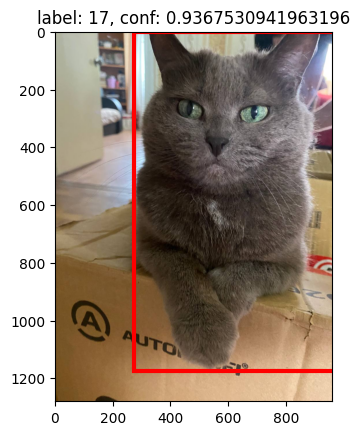

In [87]:
from matplotlib.patches import Rectangle
plt.imshow(img_plot)
ax = plt.gca()
rect = Rectangle(bbox[0:2], bbox[2], bbox[3],linewidth=3,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.set_title(f"label: {label}, conf: {score}")
print("В COCO label 17 - это cat")